# import lib

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from collections import Counter
import re
import string
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import torch
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import (
    KMeans,
    MiniBatchKMeans,
    DBSCAN,
    AgglomerativeClustering
)
from hdbscan import HDBSCAN
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)

# Project 2

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
jsonObj = pd.read_json(r'D:\social_network\crawl_readme\readme_data.jsonl', lines=True)

In [ ]:
jsonObj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57383 entries, 0 to 57382
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   repo_id    57383 non-null  object        
 1   full_name  57383 non-null  object        
 2   readme     57383 non-null  object        
 3   timestamp  57383 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 1.8+ MB


In [ ]:
jsonObj.drop_duplicates(subset=['repo_id'],inplace=True)

In [ ]:
jsonObj = jsonObj.drop(['full_name','timestamp'],axis=1)

In [ ]:
jsonObj.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57368 entries, 0 to 57382
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   repo_id  57368 non-null  object
 1   readme   57368 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB


In [ ]:
jsonObj= jsonObj.reset_index(drop=True)

##Traditional preprocessing

In [ ]:
class TextPreprocessor:
    """ Preprocess using regex and remove unecessary words"""
    def __init__(self, remove_code=True, remove_urls=True, lowercase=True):
        self.remove_code = remove_code
        self.remove_urls = remove_urls
        self.lowercase = lowercase
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

        # Add common programming keywords to stop words
        self.programming_stop_words = {
            'install', 'installation', 'usage', 'example', 'documentation',
            'license', 'contributing', 'readme', 'github', 'git','href','src','link',
            'fire','logo','bottom','language','icon','title','platform','source','like',
            'pain','convenience','summary','release','default', 'created','last', 'mark',
            'code','updated','loading','file','unless','project','title','effortlessly',
            'csinternship','found','first','favorite','favourite','app','new','awesome',
            'welcome','getting','started','trying','please','need', 'believe','feel',
            'instead','let','think','use', 'thank','everyone','anyone', 'edit','run',
            'without','see','simple', 'work','additional','information' ,'regarding',
            'copyright', 'ownership' ,'asf','needed','system','building','helped','fix',
            'discussion','fixed','install','useful','come','several','consist','of','follow',
            'want','get','unique','way','changing','making','might','can','different','know',
            'used','one','fastest','fast','also','various','could','try','noted','note',
            'contribute','to','known','professional','community','team','usually','resarch',
            'paper','download','often','rarely','never','png','conversation','karate','alt',
            'friendly', 'icon','heavy','communication', 'resource','adjust','using','pre','built',
            'optional','option','platform','bug','fix','magical','commit','main','build','version',
            'repository','img','test','issue','create','tool','support','command','add'
        }
        self.stop_words.update(self.programming_stop_words)

    def clean_text(self, text):
        """
        Clean and normalize text
        """
        if not isinstance(text, str):
            return ""

        # Remove URLs
        if self.remove_urls:
            text = re.sub(r'http\S+|www\S+|https\S+', '', text)

        # Remove code blocks (markdown)
        if self.remove_code:
            text = re.sub(r'```[\s\S]*?```', '', text)  # Code blocks
            text = re.sub(r'`[^`]*`', '', text)  # Inline code

        # Remove markdown syntax
        text = re.sub(r'#+\s', '', text)  # Headers
        text = re.sub(r'\*\*([^*]+)\*\*', r'\1', text)  # Bold
        text = re.sub(r'\*([^*]+)\*', r'\1', text)  # Italic
        text = re.sub(r'```math([^```]+)```KATEX_INLINE_OPEN[^KATEX_INLINE_CLOSE]+KATEX_INLINE_CLOSE', r'\1', text)  # Links

        # Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        # Convert to lowercase
        if self.lowercase:
            text = text.lower()

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def tokenize_and_lemmatize(self, text):
        """
        Tokenize and lemmatize text
        """
        tokens = word_tokenize(text)

        # Remove stop words and lemmatize
        tokens = [
            self.lemmatizer.lemmatize(token)
            for token in tokens
            if token not in self.stop_words and len(token) > 2
        ]

        return ' '.join(tokens)

    def preprocess(self, text):
        """
        Full preprocessing pipeline
        """
        text = self.clean_text(text)
        text = self.tokenize_and_lemmatize(text)
        return text

In [ ]:
preprocessor = TextPreprocessor()

In [ ]:
jsonObj['cleaned_text'] = jsonObj['readme'].apply(preprocessor.preprocess)

In [ ]:
#jsonObj = jsonObj.drop(['cleaned_text','word_count'],axis=1)

In [ ]:
jsonObj.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57368 entries, 0 to 57367
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   repo_id       57368 non-null  object
 1   readme        57368 non-null  object
 2   cleaned_text  57368 non-null  object
dtypes: object(3)
memory usage: 1.3+ MB


In [ ]:
jsonObj['cleaned_text'][1]

'pytorch pytorch python package provides two high level feature tensor computation numpy strong gpu acceleration deep neural network tape based autograd reuse python package numpy scipy cython extend pytorch trunk health continuous integration signal hud pytorch org toc pytorch pytorch gpu ready tensor library gpu ready tensor library dynamic neural network tape based autograd dynamic neural network tape based autograd python python imperative experience imperative experience lean lean extension extension binary binary nvidia jetson platform nvidia jetson platform prerequisite prerequisite nvidia cuda nvidia cuda amd rocm amd rocm intel gpu intel gpu pytorch pytorch dependency dependency pytorch pytorch option option docker image docker image image image image image pdf pdf previous version previous version resource resource release release tocstop pytorch learn basic pytorch granular level pytorch library consists following component component description torch tensor library numpy st

In [ ]:
jsonObj['word_count'] = jsonObj['cleaned_text'].str.split().str.len()
jsonObj = jsonObj[jsonObj['word_count'] >= 10].copy()

In [ ]:
c

In [ ]:
def plot_top_tfidf_terms(tfidf_matrix, vectorizer, top_n=20):
    # 1. Get feature names (the words/n-grams) from the vectorizer
    feature_names = np.array(vectorizer.get_feature_names_out())

    # 2. Calculate the mean TF-IDF score for each term across all documents
    mean_tfidf_scores = np.asarray(tfidf_matrix.mean(axis=0)).ravel()


    df_tfidf = pd.DataFrame({
        'Term': feature_names,
        'Score': mean_tfidf_scores
    })

    # 4. Sort the DataFrame by score select the top N
    top_terms_df = df_tfidf.sort_values(by='Score', ascending=False).head(top_n)


    plt.figure(figsize=(12, 8))
    sns.barplot(x='Score', y='Term', data=top_terms_df, palette='viridis')

    plt.title(f'Top {top_n} Most Important Terms (Mean TF-IDF Score)', fontsize=16)
    plt.xlabel('Mean TF-IDF Score', fontsize=12)
    plt.ylabel('Term', fontsize=12)
    plt.tight_layout()
    plt.show()

In [ ]:
tfidf_matrix, tfidf_vectorizer = create_tfidf_features(
    jsonObj['cleaned_text'].tolist(),
    max_features=5500,
    min_df=10,
    max_df=0.85
)

# Save top terms
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nTop 20 terms by IDF score:")
idf_scores = zip(feature_names, tfidf_vectorizer.idf_)
sorted_idf = sorted(idf_scores, key=lambda x: x[1], reverse=True)
for term, score in sorted_idf[:20]:
    print(f"  {term}: {score:.3f}")

TF-IDF matrix shape: (57123, 5500)
Vocabulary size: 5500

Top 20 terms by IDF score:
  nbsp star: 9.388
  star nbsp: 9.388
  class align: 9.314
  detail nbsp: 9.180
  awt: 9.120
  class style: 9.120
  software os: 9.063
  nbsp react: 8.957
  center font: 8.908
  flyer: 8.817
  minus sign: 8.775
  sub translation: 8.775
  cpp python: 8.734
  black hole: 8.695
  cryptoexchange net: 8.621
  translation align: 8.621
  emsp emsp: 8.519
  cryptoexchange: 8.487
  colab open: 8.456
  content back: 8.456


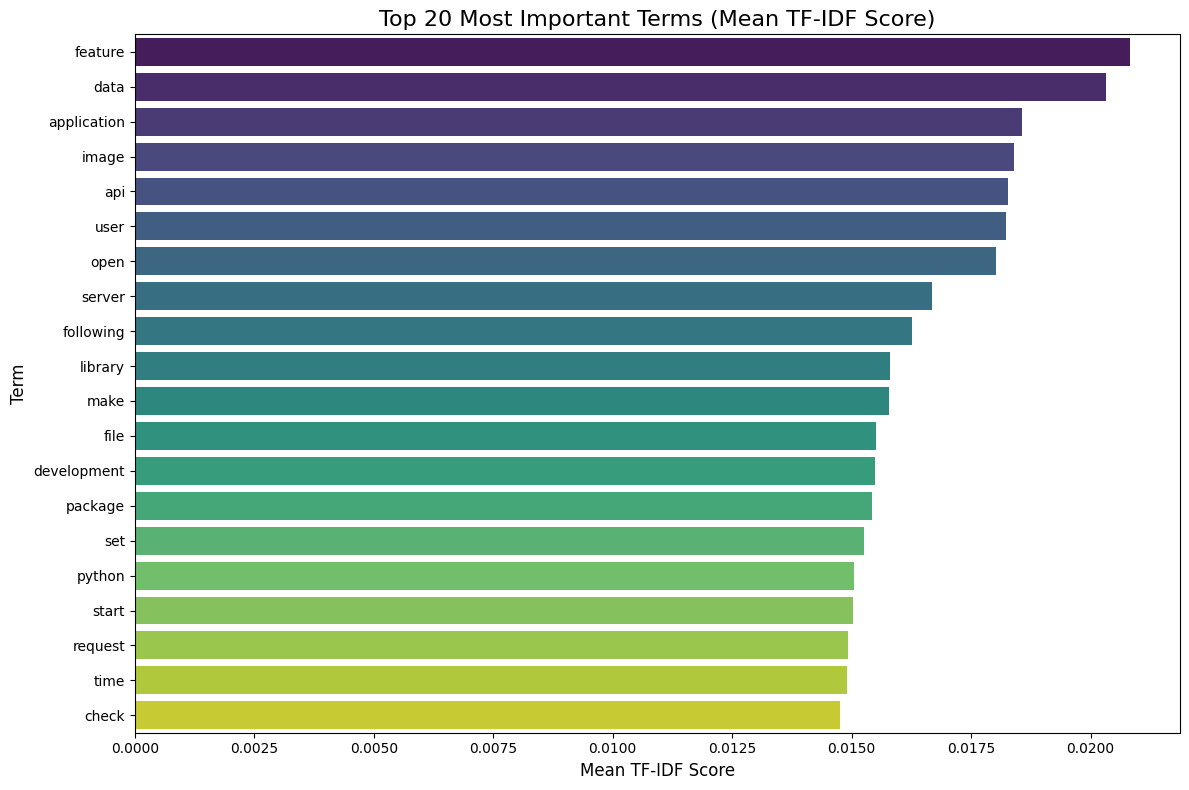

In [ ]:
plot_top_tfidf_terms(tfidf_matrix,tfidf_vectorizer)

In [ ]:
def reduce_dimensions(features, method='svd', n_components=50):
    print(f"Reducing dimensions using {method}...")

    if method == 'svd':
        # Recommended for sparse matrices (TF-IDF)
        reducer = TruncatedSVD(n_components=n_components, random_state=42)
        reduced = reducer.fit_transform(features)
        explained_var = reducer.explained_variance_ratio_.sum()
        print(f"Explained variance: {explained_var:.3f}")

    elif method == 'pca':
        # For dense matrices
        reducer = PCA(n_components=n_components, random_state=42)
        reduced = reducer.fit_transform(features.toarray() if hasattr(features, 'toarray') else features)
        explained_var = reducer.explained_variance_ratio_.sum()
        print(f"Explained variance: {explained_var:.3f}")

    elif method == 'umap':
        # Good for visualization and clustering
        reducer = umap.UMAP(n_components=n_components, random_state=42)
        reduced = reducer.fit_transform(features)

    print(f"Reduced shape: {reduced.shape}")
    return reduced, reducer


In [ ]:
reduced_features, reducer = reduce_dimensions(
    tfidf_matrix,
    method='svd',
    n_components=100
)

Reducing dimensions using svd...
Explained variance: 0.189
Reduced shape: (57123, 100)


## Using BERT Model for preprocessing

In [ ]:
class BertTextPreprocessor:
    """ Preprocess using regex and remove unecessary words"""
    def __init__(self, remove_code=True, remove_urls=True, lowercase=True):
        self.remove_code = remove_code
        self.remove_urls = remove_urls
        self.lowercase = lowercase
        self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        """
        Clean and normalize text
        """
        if not isinstance(text, str):
            return ""

        # Remove URLs
        if self.remove_urls:
            text = re.sub(r'http\S+|www\S+|https\S+', '', text)

        # Remove code blocks (markdown)
        if self.remove_code:
            text = re.sub(r'```[\s\S]*?```', '', text)  # Code blocks
            text = re.sub(r'`[^`]*`', '', text)  # Inline code

        # Remove markdown syntax
        text = re.sub(r'#+\s', '', text)  # Headers
        text = re.sub(r'\*\*([^*]+)\*\*', r'\1', text)  # Bold
        text = re.sub(r'\*([^*]+)\*', r'\1', text)  # Italic
        text = re.sub(r'```math([^```]+)```KATEX_INLINE_OPEN[^KATEX_INLINE_CLOSE]+KATEX_INLINE_CLOSE', r'\1', text)  # Links

        # Remove special characters but keep spaces
        text = re.sub(r'[^a-zA-Z\s]', ' ', text)
        # Convert to lowercase
        if self.lowercase:
            text = text.lower()

        # Remove extra whitespace
        text = ' '.join(text.split())

        return text

    def preprocess(self, text):
        """
        Full preprocessing pipeline
        """
        text = self.clean_text(text)
        return text

In [ ]:
preprocessor_bert = BertTextPreprocessor()

In [ ]:
jsonObj['cleanedText'] = jsonObj['readme'].apply(preprocessor_bert.preprocess)

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
#  initialize model
model = SentenceTransformer('all-MiniLM-L6-v2')

In [ ]:
txtlst = jsonObj['cleanedText'].tolist()
print(f"Number of texts to embed: {len(txtlst)}")

Number of texts to embed: 57123


In [ ]:
#encode text
embeddings = model.encode(txtlst,show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=True,device=device)
print(f"Embeddings created with shape: {embeddings.shape}")

In [ ]:
np.save('readme_embeddings.npy', embeddings)
print("Embeddings saved to readme_embeddings.npy")

Embeddings saved to readme_embeddings.npy


## Finding optimal k

In [ ]:
def elbow_method_basic(features, k_range=range(2, 50), use_minibatch=True):

    inertias = []
    k_values = list(k_range)

    for k in tqdm(k_values, desc="Testing k values"):
        if use_minibatch:
            kmeans = MiniBatchKMeans(
                n_clusters=k,
                random_state=42,
                batch_size=1000,
                max_iter=100,
                n_init=10
            )
        else:
            kmeans = KMeans(
                n_clusters=k,
                random_state=42,
                max_iter=100,
                n_init=10
            )

        kmeans.fit(features)
        inertias.append(kmeans.inertia_)

    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
    plt.title('Elbow Method For Optimal k', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(k_values)

    # Annotate points
    for i, (k, inertia) in enumerate(zip(k_values, inertias)):
        if i % 2 == 0:  # Annotate every other point to avoid crowding
            plt.annotate(f'{inertia:.0f}',
                        xy=(k, inertia),
                        xytext=(5, 5),
                        textcoords='offset points',
                        fontsize=8)

    plt.tight_layout()
    plt.savefig('elbow_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

    return {'k_values': k_values, 'inertias': inertias}

In [ ]:
# Run basic elbow method
results = elbow_method_basic(reduced_features, k_range=range(7, 50, 1))

Testing k values: 100%|██████████| 50/50 [00:58<00:00,  1.17s/it]


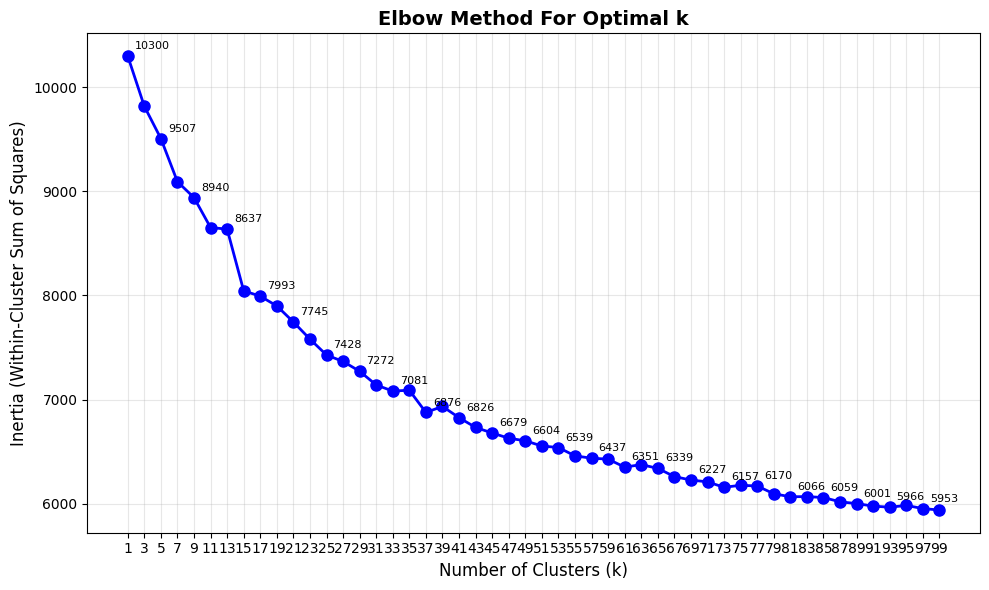

In [ ]:
a = elbow_method_basic(reduced_features, k_range=range(1, 100, 2))

In [ ]:
from sklearn.cluster import MiniBatchKMeans

In [ ]:
def plot_silhouette_scores(data_matrix, max_k=20):
    silhouette_scores = []
    k_values = range(10, max_k + 10) # Silhouette score requires at least 2 clusters

    print(f"Calculating silhouette scores for k from 2 to {max_k}")

    # Use tqdm for a progress bar, as this can be slow
    for k in tqdm(k_values, desc="Clustering Progress"):
        # Perform k-means clustering
        kmeans = MiniBatchKMeans(n_clusters=k,
        random_state=42,
        n_init=10,
        batch_size=2048)
        kmeans.fit(data_matrix)

        # Calculate the silhouette score
        score = silhouette_score(data_matrix, kmeans.labels_)
        silhouette_scores.append(score)

    # Plot the results
    plt.figure(figsize=(12, 7))
    plt.plot(k_values, silhouette_scores, 'bo-', markersize=8)
    plt.title('Silhouette Score for Optimal k', fontsize=16)
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Average Silhouette Score', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(k_values)
    plt.show()

## Finding optimal k for BERT

In [ ]:
embeddings = np.load('readme_embeddings.npy')

In [ ]:
# Quick method: Test range of clusters
def find_optimal_clusters(embeddings, k_range=range(20, 101, 10), sample_size=10000):
    results = []

    # Sample for faster computation
    if len(embeddings) > sample_size:
        indices = np.random.choice(len(embeddings), sample_size, replace=False)
        sample_embeddings = embeddings[indices]
    else:
        sample_embeddings = embeddings

    for k in k_range:
        print(f"Testing k={k}...")
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(sample_embeddings)

        inertia = kmeans.inertia_
        silhouette = silhouette_score(sample_embeddings, labels, sample_size=min(5000, len(sample_embeddings)))

        results.append({
            'k': k,
            'inertia': inertia,
            'silhouette': silhouette
        })
        print(f"  Inertia: {inertia:.2f}, Silhouette: {silhouette:.4f}")

    return pd.DataFrame(results)

# Find optimal k
results_df = find_optimal_clusters(embeddings)
print("\nResults:")
print(results_df)

# Best k by silhouette score
best_k = results_df.loc[results_df['silhouette'].idxmax(), 'k']
print(f"\nRecommended k: {best_k}")

Testing k=20...
  Inertia: 6874.49, Silhouette: 0.0318
Testing k=30...
  Inertia: 6657.82, Silhouette: 0.0317
Testing k=40...
  Inertia: 6509.47, Silhouette: 0.0320
Testing k=50...
  Inertia: 6415.33, Silhouette: 0.0293
Testing k=60...
  Inertia: 6329.20, Silhouette: 0.0286
Testing k=70...
  Inertia: 6272.04, Silhouette: 0.0266
Testing k=80...
  Inertia: 6216.96, Silhouette: 0.0251
Testing k=90...
  Inertia: 6165.26, Silhouette: 0.0252
Testing k=100...
  Inertia: 6122.54, Silhouette: 0.0229

Results:
     k      inertia  silhouette
0   20  6874.493164    0.031790
1   30  6657.821289    0.031713
2   40  6509.472656    0.031985
3   50  6415.331055    0.029257
4   60  6329.204102    0.028626
5   70  6272.040039    0.026602
6   80  6216.956055    0.025095
7   90  6165.256348    0.025181
8  100  6122.542480    0.022886

Recommended k: 40


## text clustering

In [ ]:
from sklearn.cluster import SpectralClustering

In [ ]:
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import os

class TextClusterer:
    """
    Text clustering with multiple algorithms
    """

    def __init__(self, features, save_dir="cluster_results"):
        self.features = features
        self.results = {}
        self.save_dir = save_dir
        # Tạo thư mục lưu kết quả nếu chưa tồn tại
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

    def _save_labels(self, labels, filename):
        """Lưu nhãn vào file .npy"""
        np.save(os.path.join(self.save_dir, filename), labels)
        print(f"Saved labels to {os.path.join(self.save_dir, filename)}")

    def _load_labels(self, filename):
        """Tải nhãn từ file .npy nếu tồn tại"""
        filepath = os.path.join(self.save_dir, filename)
        if os.path.exists(filepath):
            print(f"Loading labels from {filepath}")
            return np.load(filepath)
        return None

    def kmeans_clustering(self, n_clusters=20, use_minibatch=True):
        """
        K-Means clustering
        """
        filename = f"kmeans_labels_k{n_clusters}.npy"
        # Kiểm tra xem nhãn đã được lưu chưa
        cached_labels = self._load_labels(filename)
        if cached_labels is not None:
            self.results['kmeans'] = {'labels': cached_labels}
            return cached_labels

        print(f"\n{'='*50}")
        print(f"K-MEANS CLUSTERING (k={n_clusters})")
        print(f"{'='*50}")

        if use_minibatch and self.features.shape[0] > 10000:
            # MiniBatchKMeans for large datasets
            model = MiniBatchKMeans(
                n_clusters=n_clusters,
                random_state=42,
                batch_size=1000,
                n_init=10
            )
        else:
            model = KMeans(
                n_clusters=n_clusters,
                random_state=42,
                n_init=10
            )

        labels = model.fit_predict(self.features)

        # Calculate metrics
        silhouette = silhouette_score(self.features, labels, sample_size=10000)
        davies_bouldin = davies_bouldin_score(self.features, labels)
        calinski = calinski_harabasz_score(self.features, labels)

        print(f"Silhouette Score: {silhouette:.4f}")
        print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")
        print(f"Calinski-Harabasz Score: {calinski:.4f}")

        # Cluster sizes
        unique, counts = np.unique(labels, return_counts=True)
        print(f"\nCluster sizes:")
        for cluster_id, count in sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)[:10]:
            print(f"  Cluster {cluster_id}: {count} documents ({count/len(labels)*100:.1f}%)")

        self.results['kmeans'] = {
            'model': model,
            'labels': labels,
            'silhouette': silhouette,
            'davies_bouldin': davies_bouldin,
            'calinski_harabasz': calinski
        }

        # Lưu nhãn vào file
        self._save_labels(labels, filename)
        return labels

    def dbscan_clustering(self, eps=0.5, min_samples=5):
        """
        DBSCAN clustering (density-based)
        """
        filename = f"dbscan_labels_eps{eps}_min{min_samples}.npy"
        # Kiểm tra xem nhãn đã được lưu chưa
        cached_labels = self._load_labels(filename)
        if cached_labels is not None:
            self.results['dbscan'] = {'labels': cached_labels}
            return cached_labels

        print(f"\n{'='*50}")
        print(f"DBSCAN CLUSTERING (eps={eps}, min_samples={min_samples})")
        print(f"{'='*50}")

        model = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = model.fit_predict(self.features)

        # Count clusters (excluding noise: -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        print(f"Number of clusters: {n_clusters}")
        print(f"Noise points: {n_noise} ({n_noise/len(labels)*100:.1f}%)")

        if n_clusters > 1:
            # Calculate metrics (excluding noise)
            mask = labels != -1
            if mask.sum() > 0:
                silhouette = silhouette_score(self.features[mask], labels[mask])
                print(f"Silhouette Score: {silhouette:.4f}")

        # Cluster sizes
        unique, counts = np.unique(labels, return_counts=True)
        print(f"\nCluster sizes:")
        for cluster_id, count in sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)[:10]:
            label_name = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
            print(f"  {label_name}: {count} documents")

        self.results['dbscan'] = {
            'model': model,
            'labels': labels,
            'n_clusters': n_clusters
        }

        # Lưu nhãn vào file
        self._save_labels(labels, filename)
        return labels

    def spectral_clustering(self, n_clusters=20):
        """
        Spectral clustering
        """
        filename = f"spectral_labels_k{n_clusters}.npy"
        # Kiểm tra xem nhãn đã được lưu chưa
        cached_labels = self._load_labels(filename)
        if cached_labels is not None:
            self.results['spectral'] = {'labels': cached_labels}
            return cached_labels

        print(f"\n{'='*50}")
        print(f"SPECTRAL CLUSTERING (k={n_clusters})")
        print(f"{'='*50}")

        spectral = SpectralClustering(
            n_clusters=n_clusters,
            affinity='nearest_neighbors',
            random_state=42
        )

        labels = spectral.fit_predict(self.features)

        print("Clustering complete.")

        self.results['spectral'] = {
            'model': spectral,
            'labels': labels,
            'n_clusters': n_clusters
        }

        # Lưu nhãn vào file
        self._save_labels(labels, filename)
        return labels

In [ ]:
clusterer = TextClusterer(reduced_features)

In [ ]:
optimal_k = 79

In [ ]:
labels = clusterer.kmeans_clustering(n_clusters=optimal_k)

Loading labels from cluster_results\kmeans_labels_k79.npy


In [ ]:
db_labels = clusterer.dbscan_clustering(eps=0.5, min_samples=5)

Loading labels from cluster_results\dbscan_labels_eps0.5_min5.npy


In [ ]:
spectral_label = clusterer.spectral_clustering(n_clusters=optimal_k)


SPECTRAL CLUSTERING (k=79)
Clustering complete.
Saved labels to cluster_results\spectral_labels_k79.npy


In [ ]:
jsonObj['cluster_kmeans'] = labels
jsonObj['cluster_dbscan'] = db_labels

In [ ]:
jsonObj['cluster_spectral'] = spectral_label

In [ ]:
import pandas as pd
import numpy as np
import os

def analyze_clusters(df, text_column, cluster_column, vectorizer, top_n=10, save_dir="cluster_results"):
    """
    Phân tích và diễn giải các cụm, lưu kết quả chi tiết vào file text và tóm tắt vào file CSV.

    Tham số:
    - df: DataFrame chứa văn bản và nhãn cụm
    - text_column: Tên cột chứa dữ liệu văn bản
    - cluster_column: Tên cột chứa nhãn cụm
    - vectorizer: TfidfVectorizer đã được fit
    - top_n: Số lượng từ khóa hàng đầu hiển thị cho mỗi cụm
    - save_dir: Thư mục lưu kết quả tóm tắt cụm
    """
    # Kiểm tra sự tồn tại của cột
    if text_column not in df.columns:
        raise KeyError(f"Cột '{text_column}' không tồn tại trong DataFrame. Các cột hiện có: {list(df.columns)}")
    if cluster_column not in df.columns:
        raise KeyError(f"Cột '{cluster_column}' không tồn tại trong DataFrame. Các cột hiện có: {list(df.columns)}")

    # Chuẩn bị nội dung để lưu vào file text
    output_lines = ["=" * 60 + "\n", "PHÂN TÍCH CỤM\n", "=" * 60 + "\n\n"]

    print("\n" + "="*60)
    print("PHÂN TÍCH CỤM")
    print("="*60)

    cluster_info = []

    for cluster_id in sorted(df[cluster_column].unique()):
        if cluster_id == -1:  # Bỏ qua nhiễu trong DBSCAN/HDBSCAN
            continue

        cluster_docs = df[df[cluster_column] == cluster_id]

        cluster_output = [f"\n{'='*60}\n", f"CỤM {cluster_id} ({len(cluster_docs)} tài liệu)\n", f"{'='*60}\n"]
        print(f"\n{'='*60}")
        print(f"CỤM {cluster_id} ({len(cluster_docs)} tài liệu)")
        print(f"{'='*60}")

        # Lấy các từ khóa hàng đầu bằng TF-IDF
        cluster_texts = cluster_docs[text_column].tolist()

        if len(cluster_texts) > 0:
            # Tạo TF-IDF cho cụm này
            cluster_tfidf = vectorizer.transform(cluster_texts)

            # Tính điểm TF-IDF trung bình
            mean_tfidf = cluster_tfidf.mean(axis=0).A1

            # Lấy các từ khóa hàng đầu
            top_indices = mean_tfidf.argsort()[-top_n:][::-1]
            feature_names = vectorizer.get_feature_names_out()
            top_terms = [feature_names[i] for i in top_indices]
            top_scores = [mean_tfidf[i] for i in top_indices]

            cluster_output.append(f"\nTop {top_n} từ khóa:\n")
            print(f"\nTop {top_n} từ khóa:")
            for term, score in zip(top_terms, top_scores):
                cluster_output.append(f"  {term}: {score:.4f}\n")
                print(f"  {term}: {score:.4f}")

            # Hiển thị tài liệu mẫu
            cluster_output.append(f"\nTài liệu mẫu (3 tài liệu đầu tiên):\n")
            print(f"\nTài liệu mẫu (3 tài liệu đầu tiên):")
            for idx, doc in enumerate(cluster_docs.head(3).itertuples(), 1):
                # Lấy định danh tài liệu (repo_name, id hoặc chỉ số)
                doc_id = getattr(doc, 'repo_name', getattr(doc, 'id', idx))
                preview = getattr(doc, text_column)[:200]
                cluster_output.append(f"\n  Tài liệu {idx} ({doc_id}):\n")
                cluster_output.append(f"    {preview}...\n")
                print(f"\n  Tài liệu {idx} ({doc_id}):")
                print(f"    {preview}...")

            cluster_info.append({
                'cluster_id': cluster_id,
                'size': len(cluster_docs),
                'top_terms': ', '.join(top_terms[:5]),
                'percentage': len(cluster_docs) / len(df) * 100
            })

        output_lines.extend(cluster_output)

    # Tạo DataFrame tóm tắt
    cluster_summary = pd.DataFrame(cluster_info)
    cluster_summary = cluster_summary.sort_values('size', ascending=False)

    output_lines.append(f"\n{'='*60}\n")
    output_lines.append("TÓM TẮT CỤM\n")
    output_lines.append(f"{'='*60}\n")
    output_lines.append(cluster_summary.to_string(index=False) + "\n")

    print(f"\n{'='*60}")
    print("TÓM TẮT CỤM")
    print(f"{'='*60}")
    print(cluster_summary.to_string(index=False))

    # Đảm bảo thư mục lưu trữ tồn tại
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Lưu tóm tắt vào file CSV
    csv_path = os.path.join(save_dir, f'cluster_summary_{cluster_column}.csv')
    cluster_summary.to_csv(csv_path, index=False)
    output_lines.append(f"\nĐã lưu tóm tắt cụm vào {csv_path}\n")
    print(f"Đã lưu tóm tắt cụm vào {csv_path}")

    # Lưu toàn bộ kết quả chi tiết vào file text
    text_path = os.path.join(save_dir, f'cluster_summary_{cluster_column}.txt')
    with open(text_path, 'w', encoding='utf-8') as f:
        f.writelines(output_lines)
    print(f"Đã lưu kết quả phân tích cụm vào file text: {text_path}")

    return cluster_summary

In [ ]:
print(jsonObj.columns)

Index(['repo_id', 'readme', 'cleaned_text', 'word_count', 'cluster_kmeans',
       'cluster_dbscan'],
      dtype='object')


In [ ]:
# Analyze clusters k-means
cluster_summary_k = analyze_clusters(
    jsonObj,
    text_column='cleaned_text',
    cluster_column='cluster_kmeans',
    vectorizer=tfidf_vectorizer,
    top_n=10
)
print(cluster_summary_k)


PHÂN TÍCH CỤM

CỤM 0 (914 tài liệu)

Top 10 từ khóa:
  cs: 0.0953
  react: 0.0780
  html: 0.0560
  component: 0.0462
  javascript: 0.0442
  website: 0.0435
  tailwind: 0.0420
  web: 0.0412
  responsive: 0.0394
  page: 0.0380

Tài liệu mẫu (3 tài liệu đầu tiên):

  Tài liệu 1 (1):
    rio align center strong rio strong easy framework creating website apps based strong entirely python strong strong single line html cs javascript strong beautiful modern apps rio brings react style co...

  Tài liệu 2 (2):
    codsoft codsoft overview codsoft dedicated level task codsoft virtual internship find exciting project related web designing task including calculator javascript stunning landing page captivating port...

  Tài liệu 3 (3):
    web analyzer frontend web analyzer web analyzer frontend mazaoro sarlu frontend serf legacy related lead magnet web analyzer drawing inspiration hubspot popular website grader detail name web analyzer...

CỤM 1 (720 tài liệu)

Top 10 từ khóa:
  learning: 0.115

In [ ]:
# Analyze clusters dbscan
cluster_summary_db = analyze_clusters(
    jsonObj,
    text_column='cleaned_text',
    cluster_column='cluster_dbscan',
    vectorizer=tfidf_vectorizer,
    top_n=10
)
print(cluster_summary_db)


PHÂN TÍCH CỤM

CỤM 0 (57121 tài liệu)

Top 10 từ khóa:
  feature: 0.0208
  data: 0.0203
  application: 0.0186
  image: 0.0184
  api: 0.0183
  user: 0.0182
  open: 0.0180
  server: 0.0167
  following: 0.0163
  library: 0.0158

Tài liệu mẫu (3 tài liệu đầu tiên):

  Tài liệu 1 (1):
    huggingface right reserved licensed apache may except compliance may obtain copy required applicable law agreed writing software distributed distributed basis warranty condition kind either express im...

  Tài liệu 2 (2):
    pytorch pytorch python package provides two high level feature tensor computation numpy strong gpu acceleration deep neural network tape based autograd reuse python package numpy scipy cython extend p...

  Tài liệu 3 (3):
    large model scratch contains developing pretraining finetuning gpt llm official book large model scratch width large model scratch learn understand large model llm inside coding ground step step book ...

TÓM TẮT CỤM
 cluster_id  size                          

In [ ]:
# Analyze clusters spectral
cluster_summary_sp = analyze_clusters(
    jsonObj,
    text_column='cleaned_text',
    cluster_column='cluster_spectral',
    vectorizer=tfidf_vectorizer,
    top_n=10
)
print(cluster_summary_sp)


PHÂN TÍCH CỤM

CỤM 0 (1367 tài liệu)

Top 10 từ khóa:
  align: 0.1051
  align center: 0.1041
  center: 0.1008
  div: 0.0969
  target blank: 0.0734
  width: 0.0707
  blank: 0.0698
  div align: 0.0668
  height: 0.0539
  target: 0.0511

Tài liệu mẫu (3 tài liệu đầu tiên):

  Tài liệu 1 (1):
    streamlit style margin top streamlit faster share data apps streamlit streamlit let transform python script interactive web apps minute week dashboard generate report chat apps cloud deploy manage sha...

  Tài liệu 2 (2):
    align center width featuretools align center holy grail machine learning automate feature engineering process pedro domingo thing machine learning align center test target blank test status target bla...

  Tài liệu 3 (3):
    tensorflow div align center div file guide tutorial tensorflow org tensorflow read tensorflow doc contributor guide style guide doc tracker tensorflow tensorflow repo join tensorflow contributor tenso...

CỤM 1 (1117 tài liệu)

Top 10 từ khóa:
  extens

## Text clustering for BERT

In [ ]:
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import hdbscan
import os

class BertTextClustering:
    """
    Text clustering with multiple algorithms for BERT embeddings
    """

    def __init__(self, features, save_dir="cluster_results"):
        self.features = features
        self.results = {}
        self.save_dir = save_dir
        # Tạo thư mục lưu kết quả nếu chưa tồn tại
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

    def _save_labels(self, labels, filename):
        """Lưu nhãn vào file .npy"""
        filepath = os.path.join(self.save_dir, filename)
        np.save(filepath, labels)
        print(f"Saved labels to {filepath}")

    def _load_labels(self, filename):
        """Tải nhãn từ file .npy nếu tồn tại"""
        filepath = os.path.join(self.save_dir, filename)
        if os.path.exists(filepath):
            print(f"Loading labels from {filepath}")
            return np.load(filepath)
        return None

    def kmeans_clustering(self, n_clusters=20, use_minibatch=True):
        """
        K-Means clustering
        """
        filename = f"BERT_kmeans_labels_k{n_clusters}.npy"
        # Kiểm tra xem nhãn đã được lưu chưa
        cached_labels = self._load_labels(filename)
        if cached_labels is not None:
            self.results['kmeans'] = {'labels': cached_labels}
            return cached_labels

        print(f"\n{'='*50}")
        print(f"K-MEANS CLUSTERING (k={n_clusters})")
        print(f"{'='*50}")

        if use_minibatch and self.features.shape[0] > 10000:
            # MiniBatchKMeans for large datasets
            model = MiniBatchKMeans(
                n_clusters=n_clusters,
                random_state=42,
                batch_size=1000,
                n_init=10
            )
        else:
            model = KMeans(
                n_clusters=n_clusters,
                random_state=42,
                n_init=10
            )

        labels = model.fit_predict(self.features)

        # Calculate metrics
        silhouette = silhouette_score(self.features, labels, sample_size=10000)
        davies_bouldin = davies_bouldin_score(self.features, labels)
        calinski = calinski_harabasz_score(self.features, labels)

        print(f"Silhouette Score: {silhouette:.4f}")
        print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")
        print(f"Calinski-Harabasz Score: {calinski:.4f}")

        # Cluster sizes
        unique, counts = np.unique(labels, return_counts=True)
        print(f"\nCluster sizes:")
        for cluster_id, count in sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)[:10]:
            print(f"  Cluster {cluster_id}: {count} documents ({count/len(labels)*100:.1f}%)")

        self.results['kmeans'] = {
            'model': model,
            'labels': labels,
            'silhouette': silhouette,
            'davies_bouldin': davies_bouldin,
            'calinski_harabasz': calinski
        }

        # Lưu nhãn vào file
        self._save_labels(labels, filename)
        return labels

    def dbscan_clustering(self, eps=0.5, min_samples=5):
        """
        DBSCAN clustering (density-based)
        """
        filename = f"BERT_dbscan_labels_eps{eps}_min{min_samples}.npy"
        # Kiểm tra xem nhãn đã được lưu chưa
        cached_labels = self._load_labels(filename)
        if cached_labels is not None:
            self.results['dbscan'] = {'labels': cached_labels}
            return cached_labels

        print(f"\n{'='*50}")
        print(f"DBSCAN CLUSTERING (eps={eps}, min_samples={min_samples})")
        print(f"{'='*50}")

        model = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = model.fit_predict(self.features)

        # Count clusters (excluding noise: -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        print(f"Number of clusters: {n_clusters}")
        print(f"Noise points: {n_noise} ({n_noise/len(labels)*100:.1f}%)")

        if n_clusters > 1:
            # Calculate metrics (excluding noise)
            mask = labels != -1
            if mask.sum() > 0:
                silhouette = silhouette_score(self.features[mask], labels[mask])
                print(f"Silhouette Score: {silhouette:.4f}")

        # Cluster sizes
        unique, counts = np.unique(labels, return_counts=True)
        print(f"\nCluster sizes:")
        for cluster_id, count in sorted(zip(unique, counts), key=lambda x: x[1], reverse=True)[:10]:
            label_name = "Noise" if cluster_id == -1 else f"Cluster {cluster_id}"
            print(f"  {label_name}: {count} documents")

        self.results['dbscan'] = {
            'model': model,
            'labels': labels,
            'n_clusters': n_clusters
        }

        # Lưu nhãn vào file
        self._save_labels(labels, filename)
        return labels

    def hdbscan_clustering(self, min_cluster_size=15, min_samples=5):
        """
        HDBSCAN clustering (improved density-based)
        """
        filename = f"BERT_hdbscan_labels_min{min_cluster_size}_minsamples{min_samples}.npy"
        # Kiểm tra xem nhãn đã được lưu chưa
        cached_labels = self._load_labels(filename)
        if cached_labels is not None:
            self.results['hdbscan'] = {'labels': cached_labels}
            return cached_labels

        print(f"\n{'='*50}")
        print(f"HDBSCAN CLUSTERING (min_cluster_size={min_cluster_size})")
        print(f"{'='*50}")

        model = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric='euclidean',
            cluster_selection_method='eom'
        )
        labels = model.fit_predict(self.features)

        # Count clusters (excluding noise: -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        print(f"Number of clusters found: {n_clusters}")
        print(f"Noise points found: {n_noise} ({n_noise / len(labels) * 100:.1f}%)")

        if n_clusters > 1:
            # Calculate metrics (excluding noise)
            mask = labels != -1
            if mask.sum() > 0:
                silhouette = silhouette_score(self.features[mask], labels[mask], sample_size=10000)
                print(f"Silhouette Score (on non-noise points): {silhouette:.4f}")
                self.results['hdbscan'] = {'silhouette': silhouette}

        self.results['hdbscan'] = {
            'model': model,
            'labels': labels,
            'n_clusters': n_clusters
        }

        # Lưu nhãn vào file
        self._save_labels(labels, filename)
        return labels

    def spectral_clustering(self, n_clusters=20):
        """
        Spectral clustering
        """
        filename = f"BERT_spectral_labels_k{n_clusters}.npy"
        # Kiểm tra xem nhãn đã được lưu chưa
        cached_labels = self._load_labels(filename)
        if cached_labels is not None:
            self.results['spectral'] = {'labels': cached_labels}
            return cached_labels

        print(f"\n{'='*50}")
        print(f"SPECTRAL CLUSTERING (k={n_clusters})")
        print(f"{'='*50}")

        model = SpectralClustering(
            n_clusters=n_clusters,
            affinity='nearest_neighbors',
            random_state=42
        )

        labels = model.fit_predict(self.features)

        print("Clustering complete.")

        self.results['spectral'] = {
            'model': model,
            'labels': labels,
            'n_clusters': n_clusters
        }

        # Lưu nhãn vào file
        self._save_labels(labels, filename)
        return labels

In [ ]:
Bertclusterer = BertTextClustering(embeddings)

In [ ]:
# Bertclusterer_1 = BertTextClustering(embeddings_sample)

In [ ]:
optimal_k = 40

In [ ]:
Bertlabels = Bertclusterer.kmeans_clustering(n_clusters=optimal_k)


K-MEANS CLUSTERING (k=40)
Silhouette Score: 0.0269
Davies-Bouldin Score: 4.2961
Calinski-Harabasz Score: 344.4880

Cluster sizes:
  Cluster 10: 2846 documents (5.0%)
  Cluster 29: 2360 documents (4.1%)
  Cluster 20: 2246 documents (3.9%)
  Cluster 25: 2119 documents (3.7%)
  Cluster 27: 2112 documents (3.7%)
  Cluster 7: 2054 documents (3.6%)
  Cluster 23: 1920 documents (3.4%)
  Cluster 3: 1850 documents (3.2%)
  Cluster 16: 1835 documents (3.2%)
  Cluster 24: 1822 documents (3.2%)
Saved labels to cluster_results\BERT_kmeans_labels_k40.npy


In [ ]:
Bert_db_labels = Bertclusterer.dbscan_clustering(eps=0.5, min_samples=5)


DBSCAN CLUSTERING (eps=0.5, min_samples=5)
Number of clusters: 43
Noise points: 56433 (98.8%)
Silhouette Score: 0.6742

Cluster sizes:
  Noise: 56433 documents
  Cluster 32: 294 documents
  Cluster 3: 46 documents
  Cluster 23: 29 documents
  Cluster 10: 28 documents
  Cluster 2: 21 documents
  Cluster 0: 17 documents
  Cluster 5: 15 documents
  Cluster 9: 14 documents
  Cluster 7: 10 documents
Saved labels to cluster_results\BERT_dbscan_labels_eps0.5_min5.npy


In [ ]:
# Bert_spectral_label = Bertclusterer_1.spectral_clustering(n_clusters=optimal_k)


SPECTRAL CLUSTERING (k=40)
Clustering complete.
Saved labels to cluster_results\BERT_spectral_labels_k40.npy


In [ ]:
BertHDBScan = Bertclusterer.hdbscan_clustering(min_cluster_size=30, min_samples=5)


HDBSCAN CLUSTERING (min_cluster_size=30)
Number of clusters found: 17
Noise points found: 55631 (97.4%)
Silhouette Score (on non-noise points): 0.3057
Saved labels to cluster_results\BERT_hdbscan_labels_min30_minsamples5.npy


In [ ]:
jsonObj['cluster_kmeans_bert'] = Bertlabels
jsonObj['cluster_dbscan_Bert'] = Bert_db_labels
jsonObj['cluster_HBDScan_Bert'] = BertHDBScan


## Visualize

In [ ]:
import umap
import numpy as np
import pandas as pd
import umap
from sklearn.manifold import TSNE
import plotly.express as px

In [ ]:
def visualize_clusters(features, labels, method='umap', sample_size=5000):
    """
    Visualize clusters in 2D
    """
    # Sample if dataset is too large
    if features.shape[0] > sample_size:
        indices = np.random.choice(features.shape[0], sample_size, replace=False)
        features_sample = features[indices]
        labels_sample = labels[indices]
    else:
        features_sample = features
        labels_sample = labels

    if method == 'umap':
        reducer = umap.UMAP(n_components=2, random_state=42)
        embedding = reducer.fit_transform(features_sample)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        embedding = reducer.fit_transform(features_sample.toarray() if hasattr(features_sample, 'toarray') else features_sample)

    # Create DataFrame for plotting
    viz_df = pd.DataFrame({
        'x': embedding[:, 0],
        'y': embedding[:, 1],
        'cluster': labels_sample.astype(str)
    })

    # Interactive plot with Plotly
    fig = px.scatter(
        viz_df,
        x='x',
        y='y',
        color='cluster',
        title=f'Text Clusters Visualization ({method.upper()})',
        hover_data=['cluster'],
        width=1000,
        height=800
    )

    fig.update_traces(marker=dict(size=5, opacity=0.6))
    fig.show()

    return embedding

In [ ]:
embedding_2d = visualize_clusters(
    embeddings,
    jsonObj['cluster_kmeans'].values,
    method='umap',
    sample_size=5000
)

In [ ]:
embedding_2d = visualize_clusters(
    embeddings,
    jsonObj['cluster_kmeans_bert'].values,
    method='umap',
    sample_size=5000
)

In [ ]:
embedding_2d = visualize_clusters(
    embeddings,
    jsonObj['cluster_dbscan'].values,
    method='umap',
    sample_size=5000
)

In [ ]:
embedding_2d = visualize_clusters(
    embeddings,
    jsonObj['cluster_dbscan_Bert'].values,
    method='umap',
    sample_size=5000
)

In [ ]:
embedding_2d = visualize_clusters(
    embeddings,
    jsonObj['cluster_HBDScan_Bert'].values,
    method='umap',
    sample_size=5000
)

In [ ]:
embedding_2d = visualize_clusters(
    embeddings,
    jsonObj['cluster_spectral'].values,
    method='umap',
    sample_size=5000
)